<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 32
testBlockSize = 400
numVars = 2
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "2_var_dataset"

In [34]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [35]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 499035 examples, 30 unique.
id:206881
outputs:C*x2**2+C*x2+C>____________________
variables:2


In [36]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 938 examples, 30 unique.
tensor(-2.9942) tensor(2.9812)
id:141
outputs:C*log(C*x1+C*x2+C)+C>_______________
variables:2


In [37]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton



            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [38]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: 0.11403466543468799*exp(0.7814917198392037*x1)+1.5036893734519117
Predicted: 1.0*exp(1.0*x1)+1.0
Err:49.674992394121865
----------

Target: -2.0381381693323983*x2/(-0.7830278802203807*x2+1.8479618790331518)+1.3369592996603776
Predicted: 1.0*exp(1.0*x2)+1.0*cos(1.0*x2)1.0)1.0)1.01.0
Err:97.05385876098381
----------

Target: 0.5174671245230469*x1+-0.7406691809860964*x2+1.263293937708446*sin(-0.22545389409558148*x1**4)+-0.14261905522141194
Predicted: 0.32625955069631896*x1+-0.41047342356548244*x2
Err:0.05388125156985894
----------

Target: 0.5421963454724397*cos(1.8571563074073514*x2)**2+0.18268294291327036
Predicted: 1.0*exp(1.0*x2)+1.0
Err:368.88328468839916
----------

Target: 1.8925230604087453*log(-1.7005468116292088*x2)+1.4590878105891467
Predicted: 1.0*log(1.0*x2)+1.0
Err:172.92857323591102
----------

Target: -1.4907400077539474*x1**2+-1.328483913046248*x1+0.8513612467217766
Predicted: -2.108037060517235*x1**2+0.42420317829883564
Err:0.06442379764278569
----------

Target

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.9053583367442504*x1**4+-1.216126950779909*x1**5+0.6958829589802584*x1**4+1.6878790619150128*x1**3+-1.1495312664299526*x1**2+0.9962553037023425*x1+-0.05142391091897469*x2**3+-1.0947208947911722*x2**2+-0.6104932242254826*x2+0.18045098473347254
Predicted: 1.0*x1**3+1.0*x2(1.0*x2)+1.0
Err:62.58941717231074
----------

Target: 1.3564803605345777*x1**3*-1.5258223568601954*cos(1.2936107207122287*x1+-0.816481996481299)+-1.5539925056890236*x1**2+1.1026549177159826*x1+1.966953944285097
Predicted: 0.019859768274497588*x1**4+0.24377640219035615
Err:9.735643975835966
----------

Target: 1.9028873744120962*cos(0.9181670374434732*x2**2)+-1.51794926690386
Predicted: 1.0*cos(1.0*x2**++1.01.0
Err:304.3669218916776
----------

Target: -1.2639412889601456*log(1.8092537154928179*x1)+-0.16724647184994956
Predicted: 1.0*log(1.0*x1)+1.0
Err:1.024307724303204
----------

Target: -0.3513454228910202*x1+-0.43087220263767323
Predicted: 1.0*exp(1.0*x1)+1.0
Err:136.65373978545503
----------

Target: 1.71

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.9535811281546258*x2**2*-1.6425828162564033*exp(0.8423904098479942*x2)/1.8873838085789196*cos(-0.7921335210160056*x2**2+-1.2223311924313576*x2)+0.9036521121248455
Predicted: 1.0*exp(1.0*x2)+1.0*exp(1.0*x2)1.01.01.01.01.01.01.01.0)+1.01.01.01.01.0
Err:49.525535361660175
----------

Target: 0.3067950824169037*sin(1.2501292664545733*x1+0.2363231278505693)+1.1931907097737078
Predicted: 1.0*exp(1.0*x1)+1.0
Err:141.3461458474272
----------

Target: -1.1501578132690207*x1+0.03595508021675453
Predicted: -1.1501563665723704*x1+0.035954868577409586
Err:5.16249546413863e-13
----------

Target: -1.9413384036027819*x1+-1.4433599599892377
Predicted: -1.9413346242269447*x1+-1.4433546063704128
Err:2.2615877110307327e-12
----------

Target: -0.10987757208365179*x1+-1.7083365138687652*x2+1.4404329495877057
Predicted: -1.68288369808691*x2+1.434761939513316
Err:0.0022417996323897175
----------

Target: 0.32141677627113685*log(1.7407998518414423*sin(-0.29951783888388084*sin(-0.7377737888452007*x

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Streaming output truncated to the last 5000 lines.

Avg Err:336.9958744880672
Test Case 104.
Target:-1.5050244768908194*log(-1.2143811055751401*sin(0.8251751436035226*x2))+1.4560355560220337
Skeleton:1.0*log(1.0*x2)+1.0
Err:137.077498674667

Avg Err:336.9958744880672
Test Case 105.
Target:-0.5900133234742211*x1+0.1054383203713174*x2+-0.41565254722577305
Skeleton:1.0*exp(1.0*x2)1.01.0*)+1.0+1.0
Err:288.497829881855

Avg Err:336.9958744880672
Test Case 106.
Target:-2.0225283877434945*x1**6*0.24253195017177287*sin(-0.5957387778105752*x1+-0.48825384645172276*x2+0.4542579421796251)+-0.6509836555804815*x1**5+-1.305981545347294*x1**4+-1.6568668893885286*x1**3+2.0891785545091364*x1**2+1.9584622021994371*x1+-0.14800480467380273*x2**2+-1.421975757863919*x2+1.6719005977382682
Skeleton:1.0*x1**4+1.0*exp(1.0*x2)+1.0
Err:305.37210878392915

Avg Err:336.9958744880672
Test Case 107.
Target:1.640329134016441*sin(-0.18334713057779095*x1)+-0.3331611917515116
Skeleton:1.0*exp(1.0*x1)+1.0
Err:184.375683898

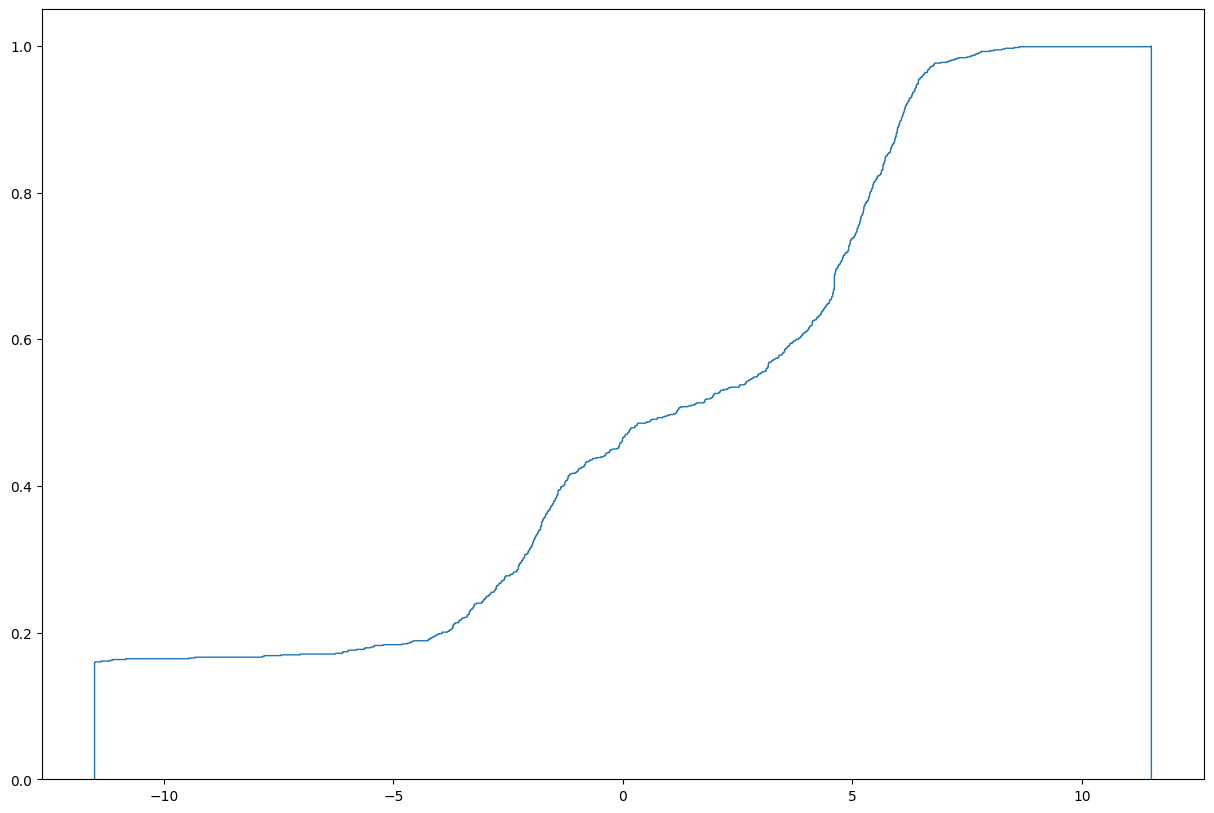

In [40]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=4,
    n_head=4,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=False,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/diffusym/2Var_tnet.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym/ddim_step_1/2_var_tnet.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)